In [615]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/naomiverkerk/TM10007.git
 

In [616]:
## Import
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from load_data import load_data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

# Classifiers and kernels
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [617]:
##Loading Data
data = load_data() 
X = data
X = X.replace(np.inf, np.nan)
col = list(range(0,data.shape[1]-1))
Y=data.drop(data.columns[col], axis = 1)
# Y = data['label']
del X['label']
del col

In [628]:
dict_split = {
    "data" : data,
}

dict_val = {
    "infinite value": [],
    "NaN value": [],
}


sum_inf = []

for item in dict_split:
    sum_inf.append(dict_split[item].isin([np.inf, -np.inf]).sum().sum())
    
dict_val['infinite value'] = sum_inf


sum_nan = []

for item in dict_split:
    sum_nan.append(dict_split[item].isna().sum().sum())

dict_val['NaN value'] = sum_nan

index = ["data"]
df = pd.DataFrame(dict_val, index=index)
df['total'] = df['infinite value'] + df['NaN value']
# df.reindex(new_index)

df

,infinite value,NaN value,total
data,1,7796,7797


In [619]:
## Split
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size = 0.2, random_state = 4, stratify = Y)

In [629]:
dict_split = {
    "X_train": X_train,
    "X_test": X_test,
    "y_train": Y_train,
    "y_test": Y_test,
}

dict_val = {
    "infinite value": [],
    "NaN value": [],
}

sum_inf = []

for item in dict_split:
    sum_inf.append(dict_split[item].isin([np.inf, -np.inf]).sum().sum())
    

dict_val['infinite value'] = sum_inf


sum_nan = []

for item in dict_split:
    sum_nan.append(dict_split[item].isna().sum().sum())


dict_val['NaN value'] = sum_nan

index = ["X_train","X_test","Y_train","Y_test"]
df = pd.DataFrame(dict_val, index=index)
df['total'] = df['infinite value'] + df['NaN value']
# df.reindex(new_index)

df


,infinite value,NaN value,total
X_train,0,3555,3555
X_test,0,1110,1110
Y_train,0,0,0
Y_test,0,0,0


In [621]:
## Features weghalen met teveel missing values
acceptabele_ratio = 0.5
train_size = len(X_train.index)
removal_rate = round(train_size*acceptabele_ratio)

X_train = X_train.dropna(axis=1, thresh=removal_rate)
common_cols = list(set(X_train.columns).intersection(X_test.columns))
X_test = X_test[common_cols]

In [622]:
## Imputation met median
X_train_missing_median = X_train.fillna(X_train.median())
X_train_missing_median = np.nan_to_num(X_train_missing_median)
X_test_missing_median = X_test.fillna(X_test.median())
X_test_missing_median = np.nan_to_num(X_test_missing_median)

In [624]:
## Scaling
scaler = preprocessing.RobustScaler()
scaler.fit(X_train_missing_median)
X_train_scaled = scaler.transform(X_train_missing_median)
X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = scaler.transform(X_test_missing_median)
X_test_scaled = np.nan_to_num(X_test_scaled)

In [651]:
scaler_y = preprocessing.LabelEncoder()
scaler_y.fit(np.array(Y_train))
Y_train_final = scaler_y.transform(np.array(Y_train))
Y_test_final =  scaler_y.transform(np.array(Y_test))

In [653]:
## PCA
pca = decomposition.PCA(n_components=0.99, svd_solver= 'full')
pca.fit(X_train_scaled)
X_train_final = pca.transform(X_train_scaled)
X_test_final = pca.transform(X_test_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)


In [663]:
dict_split = {
    "X_train": X_train_final,
    "X_test": X_test_final,
    "y_train": Y_train_final,
    "y_test": Y_test_final,
}

dict_val = {
    "infinite value": [],
    "NaN value": [],
}

sum_inf = []

for item in dict_split:
    a = pd.DataFrame(dict_split[item])
    sum_inf.append(a.isin([np.inf, -np.inf]).sum().sum())
    

dict_val['infinite value'] = sum_inf


sum_nan = []

for item in dict_split:
    a = pd.DataFrame(dict_split[item])
    sum_nan.append(a.isna().sum().sum())


dict_val['NaN value'] = sum_nan

index = ["X_train","X_test","Y_train","Y_test"]
df = pd.DataFrame(dict_val, index=index)
df['total'] = df['infinite value'] + df['NaN value']
# df.reindex(new_index)
del a
df


,infinite value,NaN value,total
X_train,0,0,0
X_test,0,0,0
Y_train,0,0,0
Y_test,0,0,0


Best classifier for parameter=0.35481338923357547
Best classifier for parameter=0.00010964781961431851
Best classifier for parameter=0.0019952623149688807
Best classifier for parameter=9.120108393559096e-06
Best classifier for parameter=0.012882495516931342
The optimal value of parameter=0.0019952623149688807


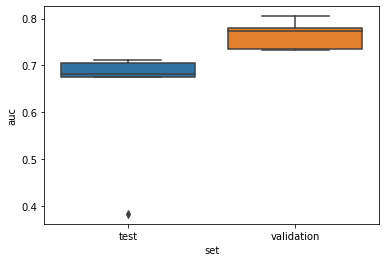

In [667]:
from sklearn.naive_bayes import GaussianNB
# # model = MultinomialNB().fit(X_train, y_train)

best_var_smoothing = []
results = []

cv_20fold = model_selection.StratifiedKFold(n_splits=5)

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_final, Y_train_final):

    # Split the data properly
    X_validation = X_train_final[validation_index]
    y_validation = Y_train_final[validation_index]
    
    X_test = X_train_final[test_index]
    y_test = Y_train_final[test_index]

    parameters = {"var_smoothing": list(np.logspace(0,-9, num=101))}
    gnb = GaussianNB()
    cv_10fold = model_selection.StratifiedKFold(n_splits=5)
    grid_search = model_selection.GridSearchCV(gnb, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier for parameter={clf.var_smoothing}')
    best_var_smoothing.append(clf.var_smoothing)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test, scores)
    results.append({
        'auc': auc,
        'k': clf.var_smoothing,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.var_smoothing,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
sns.boxplot(y='auc', x='set', data=results)

optimal_var_smoothing = (np.median(best_var_smoothing))
print(f"The optimal value of parameter={optimal_var_smoothing}")

